## Project 5. Portrait Mode

In [1]:
import os
from os.path import join
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

#### Step 1. 인물모드 직접 해 보기
* 인물 사진을 이용해 인물 외의 배경을 블러 처리
* 인물이 주인공이 아닌, 고양이에 대한 아웃포커싱 사진 생성
* 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도

* 이미지 가져오는 함수 정의

In [2]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
def load_img(img_file):
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
    my_img_path = join(img_path, img_file)
    img_orig = cv2.imread(my_img_path) 

    return img_orig, my_img_path

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
def show_img_rgb(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

* 첫번째 인물 이미지

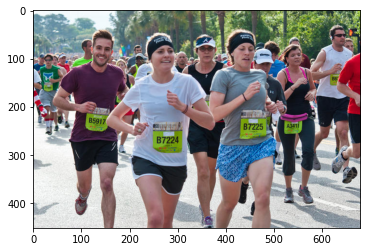

In [3]:
img_orig, my_img_path = load_img('Person1.png') 
show_img_rgb(img_orig) 

* DeepLab 모델 가져오기

In [4]:
# 저장할 파일 이름을 결정
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환 model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7faf84cd5490>)

* 모델 가져오는 함수 정의

In [5]:
def img_seg(my_img_path):
    model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

    model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
    model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
    segvalues, output = model.segmentAsPascalvoc(my_img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

    return segvalues, output

<function matplotlib.pyplot.show(close=None, block=None)>

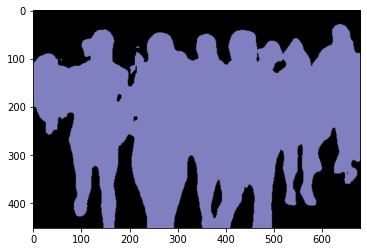

In [6]:
segvalues, output = img_seg(my_img_path)
plt.imshow(output)
plt.show

*인식되는 클래스 출력 함수 정의

In [7]:
def show_feature(segvalues):
    #pascalvoc 데이터의 라벨종류
    LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']

    #segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])

In [8]:
show_feature(segvalues)

background
person


* 이미지 내에서 원하는 특성 선택 함수 정의

In [9]:
def select_feature(label, output): 
    labels = {'background':0, 'aeroplane':1, 'bicycle':2, 'bird':3, 'boat':4, 'bottle':5,
             'bus':6, 'car':7, 'cat':8, 'chair':9, 'cow':10, 'diningtable':11, 'dog':12, 'horse':13,
             'motorbike':14, 'person':15, 'pottedplant':16, 'sheep':16, 'sofa':17, 'train':18, 'tv':19}
    
    feature = labels[label]
    #물체마다 output에 어떤 색상으로 나타나 있는지 알아내기
    #컬러맵 만들기 
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    #output 이미지가 BGR 순서로 채널 배치가 되어 있음 (colormap은 RGB 순서)
    #추출해야 하는 색상 값은 순서를 반대로    
    seg_color =((colormap[feature][2], colormap[feature][1], colormap[feature][0]))
    
    #seg_color로만 이루어진 마스크를 생성
    seg_map = np.all(output==seg_color, axis=-1) 

    return seg_map

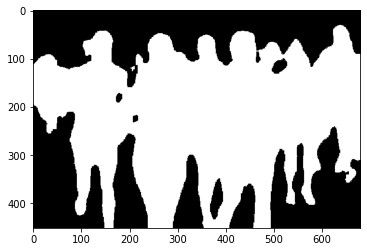

In [10]:
seg_map = select_feature('person', output)
plt.imshow(seg_map, cmap='gray')
plt.show()

* 배경 흐리게 만드는 함수 정의

In [11]:
def blur_img(img_orig, blur, seg_map):
    # blurring kernel size를 blur로
    img_orig_blur = cv2.blur(img_orig, blur)

    # True과 False인 값을 각각 255과 0으로 바꿔줌
    img_mask = seg_map.astype(np.uint8) * 255
    
    # 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽으므로 이미지 색상 채널을 BGR -> RGB 형식으로 변경 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # cv2.bitwise_not(): 이미지가 반전 (배경 0 사람 255 ->  배경 255 사람 0)
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있음
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 됨 -> 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됨 -> 배경만 남음
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    return img_bg_blur, img_mask_color
    

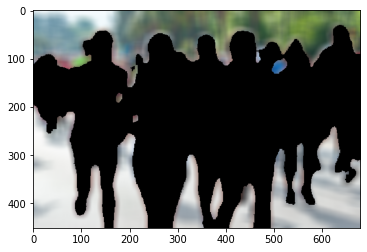

In [12]:
img_bg_blur, img_mask_color = blur_img(img_orig, (20,20), seg_map)
show_img_rgb(img_bg_blur)

* 이미지 이름 입력 시 인식되는 요소 출력 함수 정의

In [13]:
def features(img_name): 
    _, my_img_path = load_img(img_name)
    segvalues, _ = img_seg(my_img_path)
    show_feature(segvalues)

* 이미지 이름, 선택할 요소, 블러 정도를 입력하면 배경이 블러처리된 이미지 출력하는 함수 정의

In [14]:
def blur_back_img(img_name, feature, blur): 
    img_orig, my_img_path = load_img(img_name)
    _, output = img_seg(my_img_path)
    seg_map = select_feature(feature, output)
    img_bg_blur, img_mask_color = blur_img(img_orig, blur, seg_map)
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    show_img_rgb(img_concat)


*#* 이미지 이름, 배경 이름, 선택 요소 입력하면 배경을 바꾸는 함수 정의

In [15]:
def change_back_img(img_name, background_name, feature): # 이미지 이름, 배경 이름, 선택 요소 입력하면 배경을 바꿈
    img_orig, my_img_path = load_img(img_name)
    img_shape = img_orig.shape
    _, output = img_seg(my_img_path)
    seg_map = select_feature(feature, output)
    img_change, _ = load_img(background_name)
    img_changed = cv2.resize(img_change, (img_shape[1], img_shape[0])) # 배경 이미지 사이즈를 원본 이미지와 같게 만들어줌
    img_mask = seg_map.astype(np.uint8)*255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_concat = np.where(img_mask_color==255, img_orig, img_changed)
    
    show_img_rgb(img_concat)

In [16]:
features('Person1.png')

background
person


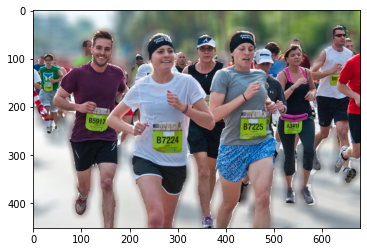

In [17]:
blur_back_img('Person1.png', 'person', (20,20))

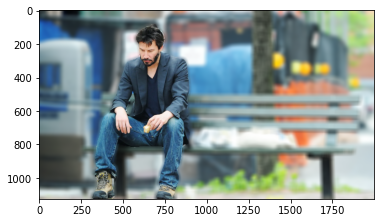

In [18]:
blur_back_img('Person2.png', 'person', (30,30))

In [19]:
features('cat1.jpg')

background
cat
chair
diningtable


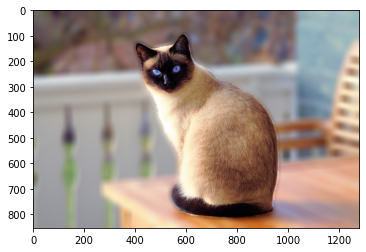

In [20]:
blur_back_img('cat1.jpg', 'cat', (30,30))

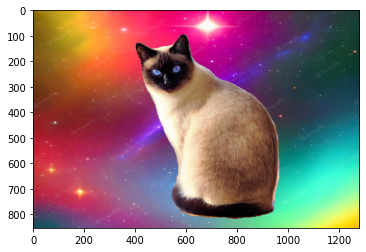

In [21]:
change_back_img('cat1.jpg', 'bg.jpg', 'cat')

#### Step 2. 사진에서 문제점 찾기

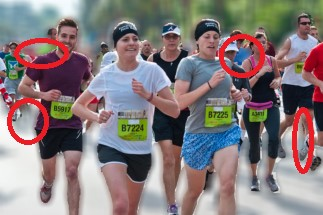
* 사람의 일부인 부분들이 상당수 블러 처리 됨, 다른 사람들로 형체 대부분이 가려져 사람의 일부로 인식이 되지 않은 듯
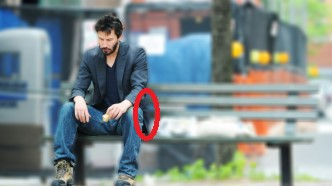
* 사람의 일부인 옷 부분이 블러 처리 됨
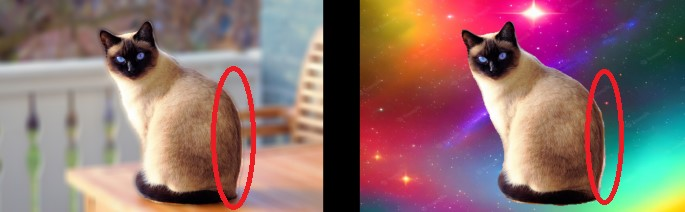
* 배경의 일부가 테두리에 남음, 분리해내는 과정에서 배경과 색상 구분이 어려운 부분이 고양이로 인식된 듯

#### Step 3. 해결 방법을 제안해 보기


* 3D 이미징을 통한 깊이 (depth) 판별 및 이를 통한 대상 객체 구분 능력 강화
######
###### 발생한 문제는 1. 인식해야 할 부분을 인식하지 못한 경우와 2. 인식하지 말아야 할 부분을 인식한 경우임
###### 인식해야 할 부분을 인식하지 못한 경우 대상 객체의 형상의 대부분이 가려져 있어 특성을 찾아내기 어렵거나 배경과 색이 너무 비슷한 경우였음
###### 인식하지 말아야 할 부분을 인식한 경우 대상 객체와 추가로 인식된 배경 부분의 색상이 비슷하여 분류가 어려운 경우였음
###### 해당 문제를 개선하기 위해 이미지를 3D로 인식하여 깊이를 바탕으로 대상 객체와 그 외 객체 및 배경을 구분하는 방안을 제안할 수 있음
###### 하드웨어 적으로는 3D 이미지 센서를 통해 이미지를 스캔하는 것으로 깊이 구분을 더할 수 있음, 하드웨어의 특성 상 비용적 문제가 있을 것
###### 소프트웨어 적으로는 구글의 struct2Depth와 monocular video에서의 깊이 구분 모델을 고려해볼 수 있음, 동영상 기반이 아니라 이미지 기반인 경우 객체의 이동이 없는 부분이 장벽으로 작용하지 않을까 싶음